In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
def set_nature_neuro_style(fig, ax):
    """
    Adjusts matplotlib figure and axes to Nature Neuroscience style.
    Supports both single and multiple axes (e.g., returned by plt.subplots).

    Parameters:
        fig : matplotlib.figure.Figure
        ax  : matplotlib.axes.Axes or np.ndarray of Axes
    """
    fig.set_size_inches(3.35, 2.5)  # standard single-column width

    # Update global font and style
    plt.rcParams.update({
        'font.family': 'Arial',
        'axes.labelsize': 7,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'legend.fontsize': 7
    })

    # Handle array of axes
    axes = ax.flatten() if isinstance(ax, np.ndarray) else [ax]

    for a in axes:
        # Hide top and right spines
        for spine in ['top', 'right']:
            a.spines[spine].set_visible(False)
        for spine in ['left', 'bottom']:
            a.spines[spine].set_linewidth(0.75)

        a.tick_params(direction='in', length=2, width=0.5, top=False, right=False)

        # legend样式调整
        leg = a.get_legend()
        if leg is not None:
            leg.get_frame().set_linewidth(0.5)
            # ✅ 使用 get_lines() 或 handles
            for lh in leg.get_lines():
                lh.set_linewidth(1.0)   # 缩小线条宽度
                lh.set_markersize(3.0)  # 缩小marker大小

    fig.tight_layout()
    fig.canvas.draw_idle()
    return fig, ax

[0.1500007  0.12400075 0.11000078 0.1020008  0.0980008  0.09700081
 0.09700081 0.0980008  0.1000008  0.10300079 0.10600079 0.11000078
 0.11400077 0.11800076 0.12300075] [0.8499993  0.87599925 0.88999922 0.8979992  0.9019992  0.90299919
 0.90299919 0.9019992  0.8999992  0.89699921 0.89399921 0.88999922
 0.88599923 0.88199924 0.87699925]
5 5
[0.15500069 0.13200074 0.12200076 0.11900076 0.11900076 0.12100076
 0.12600075 0.13100074 0.13800072 0.14600071 0.15400069 0.16300067
 0.17300065 0.18300063 0.19300061] [0.84499931 0.86799926 0.87799924 0.88099924 0.88099924 0.87899924
 0.87399925 0.86899926 0.86199928 0.85399929 0.84599931 0.83699933
 0.82699935 0.81699937 0.80699939]
3 3
[0.16800066 0.15600069 0.15600069 0.16300067 0.17500065 0.19000062
 0.20700059 0.22600055 0.24700051 0.26800046 0.28900042 0.31000038
 0.32800034 0.34600031 0.36100028] [0.83199934 0.84399931 0.84399931 0.83699933 0.82499935 0.80999938
 0.79299941 0.77399945 0.75299949 0.73199954 0.71099958 0.68999962
 0.67199966 0

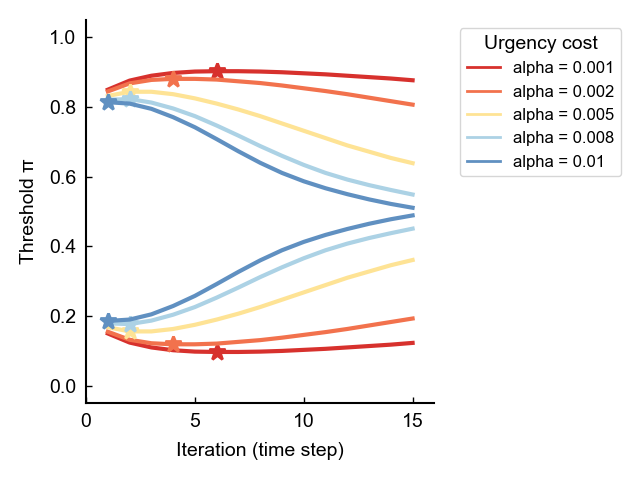

In [18]:
# ---------- Setup parameter grid ----------
param_grid = [
    {"c": 0.01, "alpha": 0.001, "mu0": -2.2, "mu1": 2.2, "sigma": 5.0},
    {"c": 0.01, "alpha": 0.002, "mu0": -2.2, "mu1": 2.2, "sigma": 5.0},
    {"c": 0.01, "alpha": 0.005, "mu0": -2.2, "mu1": 2.2, "sigma": 5.0},
    {"c": 0.01, "alpha": 0.008, "mu0": -2.2, "mu1": 2.2, "sigma": 5.0},
    {"c": 0.01, "alpha": 0.01, "mu0": -2.2, "mu1": 2.2, "sigma": 5.0}
]

max_iter = 15
N = 1001
dx = 0.01
pi = np.linspace(1e-6, 1-1e-6, N)
reward = 1

# ---------- Run simulation for each parameter set ----------
thresholds_all = []

for params in param_grid:
    c, alpha, mu0, mu1, sigma = params["c"], params["alpha"], params["mu0"], params["mu1"], params["sigma"]
    x = np.arange(mu0 - 5*sigma, mu1 + 5*sigma + dx, dx)
    f0x = norm.pdf(x, mu0, sigma)
    f1x = norm.pdf(x, mu1, sigma)

    V = np.maximum(1 - pi, pi)
    thresholds = []

    for t in range(max_iter + 1):
        V_old = V.copy()
        c_tot = c + alpha * t

        mix = pi[:, None] * f1x + (1 - pi)[:, None] * f0x
        p_post = (pi[:, None] * f1x) / mix
        V_post = np.interp(p_post, pi, V_old)
        R_samp = -c_tot + np.sum(V_post * mix, axis=1) * dx

        R0 = reward * (1 - pi)
        R1 = reward * pi
        V = np.maximum(np.maximum(R0, R1), R_samp)

        policy = np.argmax(np.vstack([R0, R1, R_samp]), axis=0)
        idx = np.where(policy == 2)[0]
        if idx.size:
            thresholds.append((pi[idx[0]], pi[idx[-1]]))
        else:
            thresholds.append((np.nan, np.nan))

    thresholds_all.append(np.array(thresholds))

# ---------- Plot thresholds ----------

plt.figure(figsize=(8, 6))

colors = ['#d7312d', '#f2724d', '#fee395', '#acd2e5', '#6090c1']
iters = np.arange(1, max_iter + 1)
for i, ths in enumerate(thresholds_all):
    low, high = ths[:, 0], ths[:, 1]

    low = low[1:]
    high = high[1:]

    print(low, high)

    plt.plot(iters, low, linestyle='-', color=colors[i], label=f'alpha = {param_grid[i]["alpha"]}')
    plt.plot(iters, high, linestyle='-',  color=colors[i])

    # Mark the highest and lowest thresholds with asterisk
    min_idx_low = np.nanargmin(low)
    max_idx_high = np.nanargmax(high)
    print(min_idx_low, max_idx_high)
    plt.plot(iters[min_idx_low], low[min_idx_low], marker='*', markersize=6, color=colors[i])
    plt.plot(iters[max_idx_high], high[max_idx_high], marker='*', markersize=6, color=colors[i])

plt.xlabel('Iteration (time step)')
plt.ylabel('Threshold π')
# plt.title('Sampling Thresholds Across Parameter Sets')
plt.xlim(0, max_iter + 1)
plt.ylim(-0.05, 1.05)
plt.legend(title="Urgency cost", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, title_fontsize=7)
plt.tight_layout()

set_nature_neuro_style(plt.gcf(), plt.gca())

plt.savefig('sampling_thresholds_across_urgency_cost.svg', dpi=300)
plt.show()

In [43]:
print(np.random.choice(8, p=[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]))

2
